In [2]:
import os
import sys
from urllib.request import urlretrieve
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from keras.applications import vgg16
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def preprocess_image(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [4]:
def deprocess_image(x, gradient=False):
    img = x.copy()
    img = img.reshape(x.shape[1], x.shape[2], x.shape[3])
    
    if gradient:
        img = (img - img.mean())*255 / img.std()
    
    else:
        img[:, :, 0] += 103.939
        img[:, :, 1] += 116.779
        img[:, :, 2] += 123.68
        
    img = img[:, :, -1]
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img

In [24]:
def main(image_path, num_pool_layers=5, iter_count=3, step=100, learning_rate=10,
         show_rand=False):
    image = preprocess_image(image_path)
    model = vgg16.VGG16(weights="imagenet", include_top=False)
    layer_dict = dict([(layer.name, layer) for layer in model.layers])

    fig = plt.figure(figsize=(17,8))
    dream = model.input
    
    for i in range(num_pool_layers):
        _image = image.copy()
        rand_input = np.random.randint(100, 150, size=_image.shape, dtype=np.uint8)
        layer_name = "block{:d}_pool".format(i+1)
        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output)
        grads = K.gradients(loss, dream)[0]
        grads /= K.maximum(K.mean(K.abs(grads)), 1e-5)
        converter = K.function([dream], [loss, grads])
        
        grad_sum = None
        
        for j in range(iter_count):
            _loss_value, _grads_value = converter([_image])
            _image += _grads_value * learning_rate
            if show_rand:
                _, _grads_value = converter([rand_input])
            if grad_sum is None:
               grad_sum = _grads_value
            else:
                grad_sum += _grads_value
                
        grad_mean = grad_sum / iter_count
        
        
        ax = plt.subplot(2, num_pool_layers, i + 1)
        ax.imshow(deprocess_image(_image))
        ax.axis("off")
        ax.set_title("dream from {}".format(layer_name))

        ax = plt.subplot(2, num_pool_layers, num_pool_layers + i + 1)
        ax.imshow(deprocess_image(grad_mean, gradient=True))
        ax.axis("off")
        ax.set_title("{}'s gradient".format(layer_name))
        
    plt.tight_layout()
    dir_name, file_name = os.path.split(image_path)
    file_root, ext = os.path.splitext(file_name)
    
    number = None
    if os.path.exists(os.path.join(dir_name, file_root + "_deep_dream"+str(number)+".png")):
        number = 0
    while (os.path.exists(os.path.join(dir_name, file_root + "_deep_dream"+str(number)+".png"))):
        number += 1
    plt.savefig(os.path.join(dir_name, file_root + "_deep_dream"+str(number)+".png"))
    plt.show()

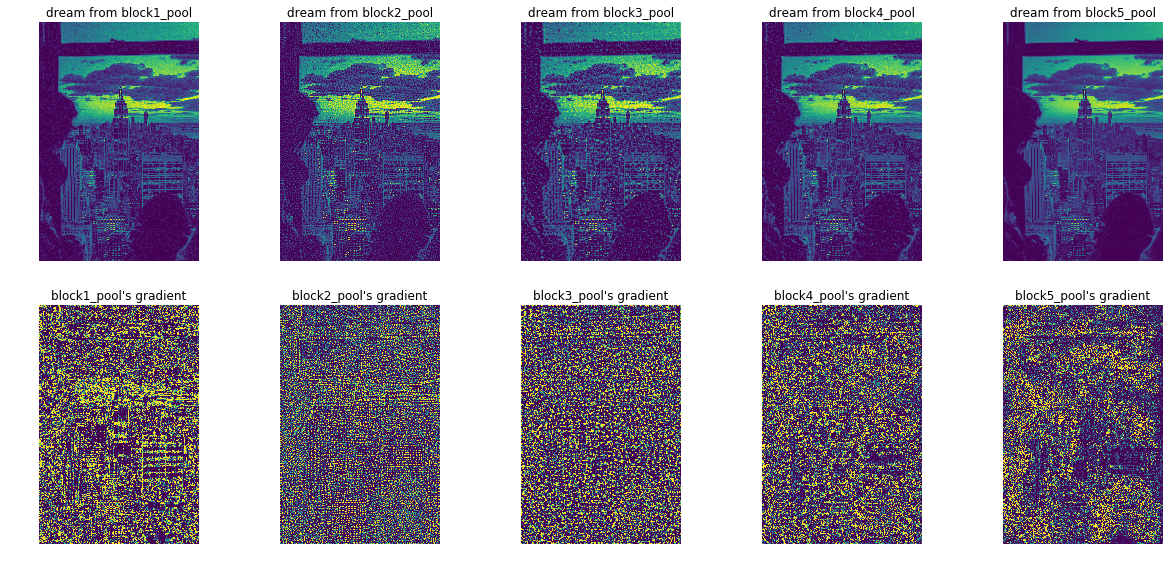

In [27]:
image_url = "https://images.unsplash.com/photo-1560775664-5010c750aeed?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=668&q=80"
data_path = os.path.join(os.path.dirname('__file__'), "data/cat.jpg")
urlretrieve(image_url, data_path)

main(data_path)

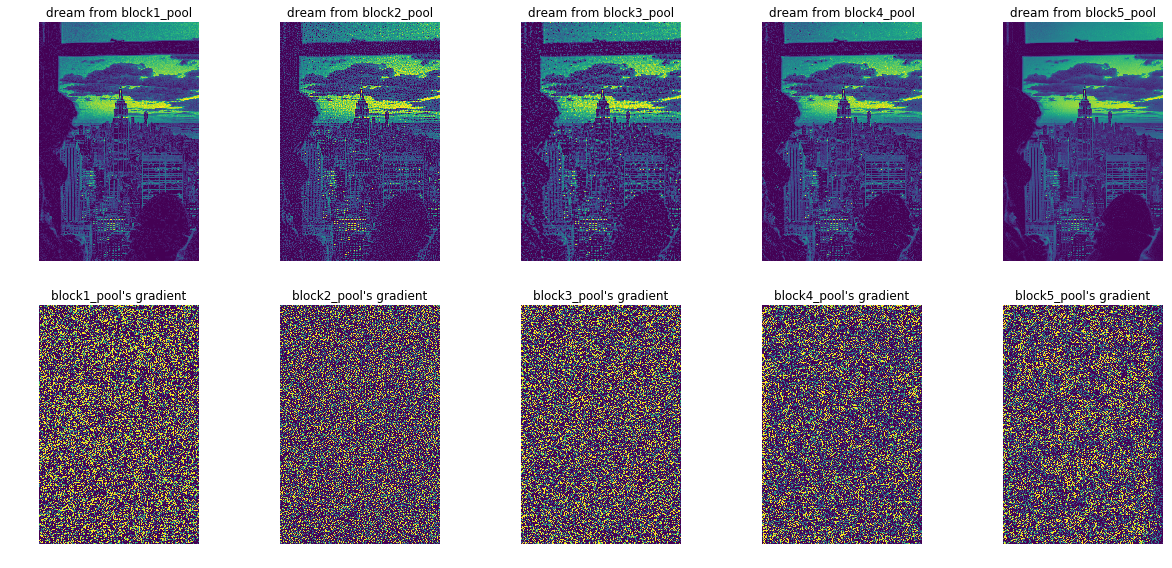

In [28]:
main(data_path, show_rand=True)